# In this Notebook, RMSprop was used as the compiler

In [ ]:
# !unzip /content/gdrive/MyDrive/data/train_EVERYTHING.zip > /dev/null
# !unzip /content/gdrive/MyDrive/IDRid_train_floder/fianl_IDRiD_train_images.zip > /dev/null
# !unzip /content/gdrive/MyDrive/test_IDRiD_test/test_image2s.zip > /dev/null
# !unzip /content/gdrive/MyDrive/aptos-folder/train_aptos.zip > /dev/null
# !unzip /content/gdrive/MyDrive/resized-folder/train_resized.zip > /dev/null

In [ ]:
# !pip install tensorflow-addons > /dev/null
# !pip install keras_tuner > /dev/null
# !pip install tensorflow > /dev/null
# !pip install tqdm


# Cleaning and  EDA


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import seaborn as sns
import re
import logging, os
import time
from tqdm import tqdm

import tensorflow as tf
import keras
from keras.models import Model, save_model
from keras.models import Sequential
#**Import from keras_preprocessing not from keras.preprocessing**
from keras.preprocessing import image
from keras_preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import regularizers, optimizers, applications
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import layers
import tensorflow_addons as tsa
from tensorflow_addons.optimizers import AdamW


from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

/tmp/ipykernel_17758/3636123741.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-29 20:45:58.289954: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 20:45:58.289998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 20:45:58.291186: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable 

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2024-02-29 20:46:07.793787: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-29 20:46:07.794305: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-29 20:46:07.794787: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Aptos 2019 Dataset

In [3]:
aptos = pd.read_csv('retinopathy_data/aptos_2019_train.csv')
#aptos_test = pd.read_csv('Aptos2019-Blindness-Detection-Kaggle/test.csv')

aptos.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [4]:
aptos.diagnosis.value_counts()

diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64

### Having a look at examples of Diabetic Retinopathy (DR) and no Diabetic Retinopathy

In [4]:
train_images = "retinopathy_data/train_EVERYTHING/"

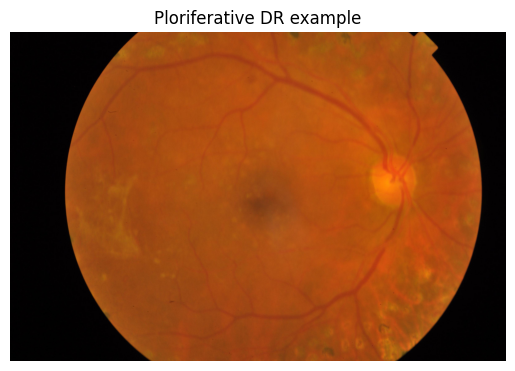

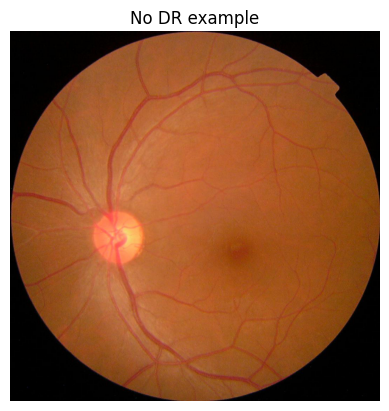

In [5]:
img = load_img(train_images +  aptos['id_code'].iloc[1]+".png")
plt.imshow(img)
plt.title('Ploriferative DR example')
plt.axis("off")
plt.show()
img = load_img(train_images +  aptos['id_code'].iloc[3] +".png")
plt.imshow(img)
plt.title('No DR example')
plt.axis("off")
plt.show()

### We'll have to add .png to the end of all those values in the id_label column if we're going to be able to connect them with the image files, and we'll also have to turn the diagnosis labels from into to str

In [6]:
aptos.id_code = aptos.id_code.apply(lambda x : "{}{}".format(x, ".png"))

aptos.diagnosis = aptos.diagnosis.astype(str)

type(aptos.diagnosis.iloc[0])

str

## Grabbing half the 0 labels as a step toward achieving class balance in the dataset

In [7]:
df_odd = aptos[aptos['diagnosis'] == '0']
df_odd.head()

,id_code,diagnosis
3,002c21358ce6.png,0
4,005b95c28852.png,0
6,0097f532ac9f.png,0
10,00cc2b75cddd.png,0
12,00f6c1be5a33.png,0


### Locating only odd rows with label 0

In [8]:
df_odd = df_odd.loc[df_odd.index % 2 == 1, :]
print(len(df_odd))

890


We have to drop all of the original rows containing label 0. Don't worry we'll replace them with half the original amount

In [9]:
aptos = aptos[aptos['diagnosis'] != '0']
print(aptos['diagnosis'].value_counts())

diagnosis
2    999
1    370
4    295
3    193
Name: count, dtype: int64


Here, see I told you we'd put half of them back in

In [10]:
aptos = pd.concat([aptos, df_odd], ignore_index=True)
aptos['diagnosis'].value_counts()

diagnosis
2    999
0    890
1    370
4    295
3    193
Name: count, dtype: int64

## IDRiD Train DataSet

In [11]:
idrid = pd.read_csv('retinopathy_data/IDRiD_train_labels.csv')

idrid.head()

,Image name,Retinopathy grade,Risk of macular edema,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,IDRiD_001,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IDRiD_002,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IDRiD_003,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IDRiD_004,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IDRiD_005,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Renaming our two columns of interest

In [12]:
idrid = idrid.rename(columns={"Image name": "id_code", "Retinopathy grade": "diagnosis"})

idrid.head()

,id_code,diagnosis,Risk of macular edema,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,IDRiD_001,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IDRiD_002,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IDRiD_003,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IDRiD_004,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IDRiD_005,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Adding .png to the Image names

In [13]:
idrid['id_code'] = idrid['id_code'].apply(lambda x : "{}{}".format(x, ".jpg"))
idrid.head()

,id_code,diagnosis,Risk of macular edema,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,IDRiD_001.jpg,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IDRiD_002.jpg,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IDRiD_003.jpg,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IDRiD_004.jpg,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IDRiD_005.jpg,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Converting the Retinopathy diagnosis to str

In [14]:
idrid['diagnosis'] = idrid['diagnosis'].astype(str)

### We're not interested in anything but the image id number (Image name) and Retinopathy grade columns. So let's drop all other columns

In [15]:
idrid = idrid[['id_code', 'diagnosis']]

idrid.head()

,id_code,diagnosis
0,IDRiD_001.jpg,3
1,IDRiD_002.jpg,3
2,IDRiD_003.jpg,2
3,IDRiD_004.jpg,3
4,IDRiD_005.jpg,4


That looks like our aptos df from above. That's good. Now let's see how many of each label we're working with

In [16]:
idrid.diagnosis.value_counts()

diagnosis
2    136
0    134
3     74
4     49
1     20
Name: count, dtype: int64

### All 0 labels

In [17]:
idrid.loc[idrid['diagnosis']== '0']

idrid.head()

,id_code,diagnosis
0,IDRiD_001.jpg,3
1,IDRiD_002.jpg,3
2,IDRiD_003.jpg,2
3,IDRiD_004.jpg,3
4,IDRiD_005.jpg,4


Quick look at aptos df too

In [18]:
aptos.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,0083ee8054ee.png,4
4,00a8624548a9.png,2


### There. Now we can concatenate the two DataFrames and make one dataframe

In [19]:
df = pd.concat([aptos, idrid], ignore_index = True)

df.tail(10)
# looks like the idrid dataframe is at the bottom like we wanted

,id_code,diagnosis
3150,IDRiD_404.jpg,2
3151,IDRiD_405.jpg,2
3152,IDRiD_406.jpg,0
3153,IDRiD_407.jpg,2
3154,IDRiD_408.jpg,1
3155,IDRiD_409.jpg,2
3156,IDRiD_410.jpg,2
3157,IDRiD_411.jpg,2
3158,IDRiD_412.jpg,2
3159,IDRiD_413.jpg,2


In [20]:
# let's check that aptos is at the top
df.head(10)
# it is

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,0083ee8054ee.png,4
4,00a8624548a9.png,2
5,00b74780d31d.png,2
6,00cb6555d108.png,1
7,00e4ddff966a.png,2
8,0104b032c141.png,3
9,0124dffecf29.png,1


How's the balance between classes looking

In [21]:
df['diagnosis'].value_counts()

diagnosis
2    1135
0    1024
1     390
4     344
3     267
Name: count, dtype: int64

Not great, but be patient, I've already gone ahead and done some work (hint: they even out)

# Bring in the Bohemoth 2015 Aptos Training Set

In [22]:
aptos15 = pd.read_csv('retinopathy_data/aptos-2015-training.csv')
aptos15.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [23]:
len(aptos15)

35126

### Let's rename the columns, for soliderity's sake

In [24]:
aptos15.rename(columns={"image": "id_code", "level": "diagnosis"}, inplace=True)

### adding jpg to the end of aptos15 id_code records and converting diagnosis column to str

In [25]:
aptos15.id_code = aptos15.id_code.apply(lambda x : "{}{}".format(x, ".jpg"))

aptos15.diagnosis = aptos15.diagnosis.astype(str)

In [26]:
aptos15.head()

,id_code,diagnosis
0,10_left.jpg,0
1,10_right.jpg,0
2,13_left.jpg,0
3,13_right.jpg,0
4,15_left.jpg,1


In [27]:
aptos15['diagnosis'].value_counts()

diagnosis
0    25810
2     5292
1     2443
3      873
4      708
Name: count, dtype: int64

### We're going to drop the 0 labels all together for now

In [28]:
aptos15 = aptos15[aptos15['diagnosis'] !='0']

aptos15

,id_code,diagnosis
4,15_left.jpg,1
5,15_right.jpg,2
6,16_left.jpg,4
7,16_right.jpg,4
9,17_right.jpg,1
...,...,...
35098,44323_left.jpg,1
35099,44323_right.jpg,1
35105,44328_right.jpg,1
35112,44337_left.jpg,1


## Let's Get Just Half the Rows for Diagnosis 1

In [29]:
df_even = aptos15[aptos15['diagnosis'] == '1']
df_even

df_even = df_even.loc[df_even.index % 2 == 0, :]
len(df_even)

1212

### We'll use df_even a little bit down the road

In [30]:
aptos15['diagnosis'].value_counts()

diagnosis
2    5292
1    2443
3     873
4     708
Name: count, dtype: int64

### Getting rid of all the diagnosis 1 rows in aptos 15 now that we have the amount in df_even that we need

In [31]:
aptos15 = aptos15[aptos15['diagnosis'] != '1']

In [32]:
aptos15['diagnosis'].value_counts()

diagnosis
2    5292
3     873
4     708
Name: count, dtype: int64

In [33]:
aptos15 = aptos15[aptos15['diagnosis'].isin(['3','4'])]
aptos15['diagnosis'].value_counts()

diagnosis
3    873
4    708
Name: count, dtype: int64

In [34]:
aptos15['diagnosis'].unique()

array(['4', '3'], dtype=object)

# We're bringing in the test data from IDRiD because...more

In [35]:
test_idrid = pd.read_csv('retinopathy_data/IDRiD_test_labels.csv')
test_idrid = test_idrid.drop(test_idrid.columns[[2]], axis=1) # Drop Macular Adema column
test_idrid.head()

,Image name,Retinopathy grade
0,IDRiD_001,4
1,IDRiD_002,4
2,IDRiD_003,4
3,IDRiD_004,4
4,IDRiD_005,4


In [36]:
# frist change the names of columns to match other dataframes
# then add .png to image name column and turning Retinopathy grade values to str

test_idrid.rename(columns={"Image name": "id_code", "Retinopathy grade": "diagnosis"}, inplace=True)

test_idrid['id_code'] = test_idrid['id_code'].apply(lambda x : "{}{}".format("test_" + x, ".jpg"))

test_idrid['diagnosis'] =  test_idrid['diagnosis'].astype(str)

test_idrid.head()

,id_code,diagnosis
0,test_IDRiD_001.jpg,4
1,test_IDRiD_002.jpg,4
2,test_IDRiD_003.jpg,4
3,test_IDRiD_004.jpg,4
4,test_IDRiD_005.jpg,4


In [37]:
test_idrid['diagnosis'].value_counts()

diagnosis
0    34
2    32
3    19
4    13
1     5
Name: count, dtype: int64

drop all but values 3, 4 and 0

In [38]:
test_idrid = test_idrid[test_idrid['diagnosis'].isin(['0','3','4'])]
test_idrid.head()

,id_code,diagnosis
0,test_IDRiD_001.jpg,4
1,test_IDRiD_002.jpg,4
2,test_IDRiD_003.jpg,4
3,test_IDRiD_004.jpg,4
4,test_IDRiD_005.jpg,4


In [39]:
test_idrid['diagnosis'].unique()

array(['4', '3', '0'], dtype=object)

### combing test_idrid and df

In [40]:
df = pd.concat([df, test_idrid], ignore_index=True)

df.tail(5)

,id_code,diagnosis
3221,test_IDRiD_096.jpg,0
3222,test_IDRiD_097.jpg,0
3223,test_IDRiD_098.jpg,0
3224,test_IDRiD_099.jpg,0
3225,test_IDRiD_103.jpg,0


In [41]:
df = pd.concat([df, test_idrid], ignore_index=True)

df.tail()

,id_code,diagnosis
3287,test_IDRiD_096.jpg,0
3288,test_IDRiD_097.jpg,0
3289,test_IDRiD_098.jpg,0
3290,test_IDRiD_099.jpg,0
3291,test_IDRiD_103.jpg,0


In [42]:
df['diagnosis'].value_counts()

diagnosis
2    1135
0    1092
1     390
4     370
3     305
Name: count, dtype: int64

dropping all the l labels fromt the datarame

In [43]:
df = df[df['diagnosis'] != '1']

### Enter our df_even from above. Let's combine it with df

In [44]:
df = pd.concat([df, df_even], ignore_index=True)

df['diagnosis'].value_counts()

diagnosis
1    1212
2    1135
0    1092
4     370
3     305
Name: count, dtype: int64

### Now combine aptos 15

In [45]:
df = pd.concat([df, aptos15], ignore_index=True )

### Hey look at that, all our labels seem to be around the same amount. All that work payed off

In [46]:
df['diagnosis'].value_counts()

diagnosis
1    1212
3    1178
2    1135
0    1092
4    1078
Name: count, dtype: int64

### Percentage-wise?

In [47]:
df['diagnosis'].value_counts(normalize=True)

diagnosis
1    0.212818
3    0.206848
2    0.199298
0    0.191747
4    0.189289
Name: proportion, dtype: float64

Looks good to me, they're all around 20%


In [48]:
counts = df['diagnosis'].value_counts(normalize=True)

### A look at the Labels distribution

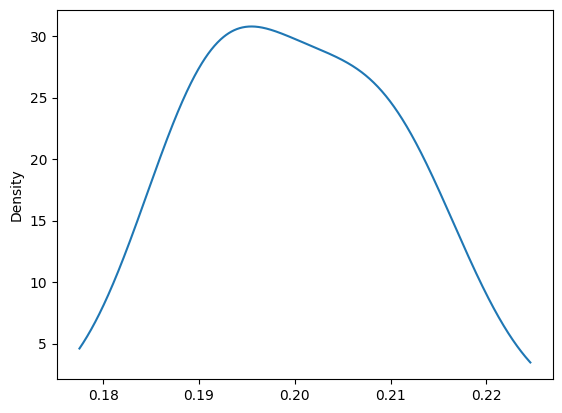

In [49]:
counts.plot.kde();

### That looks like a bell to me. Let's see the labels in bar-form

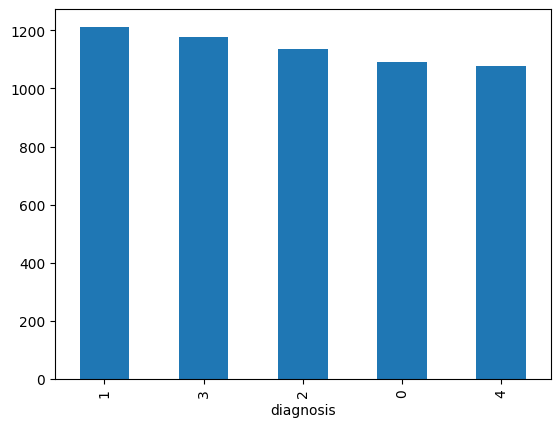

In [50]:
df['diagnosis'].value_counts().plot(kind='bar');

## Much better
the dataset looks fairly balanced, ready to run through a model I'd say

## How many images are we working with?

In [51]:
print(len(df))
print("Cool We've got more than 5,000 retinas to work with!")

5695
Cool We've got more than 5,000 retinas to work with!


# Let's break off some dedicated rows and set them aside to test on

In [52]:
train=df.sample(frac=0.8,random_state = 42)
test=df.drop(train.index)

# First Thing's First

## –The Baseline Model–

In [53]:
from sklearn.dummy import DummyClassifier

X = df['id_code']
y = df['diagnosis']

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)
DummyClassifier(strategy='most_frequent')
dummy_clf.predict(X)

dummy_clf.score(X, y)


0.2128182616330114

This totally lines up with the idea of a model picking the most frequent class, since pretty much all our labels made up 20% of the data, after cleaning. It's not surprising that we have about 20% accuracy from our baseline.  

## I have a feeling we can do better than that

# Using flow_from_dataframe( ) and ImgageDataGenerator( ) to create train, test, validation data

In [54]:
#bs = 32    #batch size
mirrored_strategy = tf.distribute.MirroredStrategy()

BATCH_SIZE_PER_REPLICA = 25
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * mirrored_strategy.num_replicas_in_sync

#Train ImageDataGenerator
datagen=ImageDataGenerator(rescale=1./255.,
                          brightness_range=(0.97, 1.1),
                           #rotation_range=12,
                           #shear_range=0.25,
                           #zoom_range=0.25,
                           #height_shift_range=0.2,
                           #width_shift_range=0.2,
                           horizontal_flip=True,
                           vertical_flip=True,
                           validation_split=0.20
                           )

# Train flow_from_dataframe
train_generator=datagen.flow_from_dataframe(
dataframe=train, # using train dataframe set apart from test dataframe, above
directory="retinopathy_data/train_EVERYTHING/",
validate_filenames = False,
x_col="id_code",
y_col="diagnosis",
subset="training",
batch_size=BATCH_SIZE,
shuffle=True,
class_mode="categorical",
target_size=(224,224))



# Validate ImageGenerator
valgen = ImageDataGenerator(rescale=1./255., validation_split=0.20)

# Validate flow_from_dataframe
valid_generator=valgen.flow_from_dataframe(
dataframe=train, # using train dataframe set apart from test dataframe, above
directory="retinopathy_data/train_EVERYTHING/",
validate_filenames = False,
x_col="id_code",
y_col="diagnosis",
subset="validation",
batch_size=BATCH_SIZE,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(224,224))



# Test ImageDataGenerator
test_datagen=ImageDataGenerator(rescale=1./255.) # no split required for test

# Test flow_from_dataframe
test_generator=test_datagen.flow_from_dataframe(
dataframe=test, # using test dataframe set aside above
directory="retinopathy_data/train_EVERYTHING/",
validate_filenames = False,
x_col="id_code",
y_col="diagnosis",
batch_size=1,
seed=42,
shuffle=False,
class_mode="categorical",
target_size=(224,224))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4')


2024-02-29 20:51:36.294716: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-29 20:51:36.295665: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-29 20:51:36.296479: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 3645 non-validated image filenames belonging to 5 classes.
Found 911 non-validated image filenames belonging to 5 classes.
Found 1139 non-validated image filenames belonging to 5 classes.


# Omicron Model

## Now Let's use ResNet50_V2 but replace the last layer with our own

In [56]:
from keras.applications.resnet_v2 import ResNet50V2

learning_rate=0.0001


with mirrored_strategy.scope():
  def create_model():
    base_model_omicron = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224,224,3)) # from 512

    x = base_model_omicron.output


    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation= 'relu')(x)
    x = Dropout(.25)(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(.25)(x)
    x = Dense(64, activation = 'relu')(x)
    x = Dropout(.25)(x)

    x = Flatten()(x)
    x = Dense(1024, activation = 'relu')(x)
    x = Dropout(.5)(x)






    predictions = Dense(5, activation= 'softmax')(x)

    for layer in base_model_omicron.layers:
      layer.trainable = True

    resnet_model_omicron = Model(inputs=base_model_omicron.input,  outputs=predictions)
    return resnet_model_omicron

  resnet_model_omicron = create_model()
  resnet_model_omicron.compile(Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy']) # compile the model


Below is the **AdamW** compiler code if needed

In [57]:
# thanks to hugoych on https://github.com/tensorflow/addons/issues/844

# lr_schedule = tf.optimizers.schedules.ExponentialDecay(1e-4, 100, 0.9)
# wd_schedule = tf.optimizers.schedules.ExponentialDecay(5e-6, 100, 0.99)
# opt = AdamW(learning_rate=lr_schedule, weight_decay=lambda : None)
# opt.weight_decay = lambda : wd_schedule(opt.iterations)

In [58]:
# class DecayHistory(tf.keras.callbacks.Callback):
#     def on_train_begin(self, logs={}):
#         self.lr = []
#         self.wd = []
#     def on_batch_end(self, batch, logs={}):
#         self.lr.append(self.model.optimizer.lr(self.model.optimizer.iterations))
#         self.wd.append(self.model.optimizer.weight_decay)

In [59]:
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=7),
         ModelCheckpoint(filepath='Adam_best_model', monitor='val_loss', save_best_only=True)]

## Fit *Omicron Model*

In [60]:
epochs = 2

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

history = resnet_model_omicron.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks=callbacks)

Epoch 1/2
INFO:tensorflow:Collective all_reduce tensors: 182 all_reduces, num_devices = 5, group_size = 5, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 182 all_reduces, num_devices = 5, group_size = 5, implementation = CommunicationImplementation.NCCL, num_packs = 1


2024-02-29 20:53:48.335416: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-29 20:53:48.366507: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-29 20:53:48.397769: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-29 20:53:48.428761: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-29 20:53:48.460803: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-29 20:53:57.692663: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f7f71d90bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-29 20:53:57.692693: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-02-29 20:53:57.692699: I external/local_xla/xla/service/service.

29/29 [==============================] - ETA: 0s - loss: 1.5705 - accuracy: 0.2847INFO:tensorflow:Assets written to: Adam_best_model/assets


INFO:tensorflow:Assets written to: Adam_best_model/assets


29/29 [==============================] - 306s 7s/step - loss: 1.5705 - accuracy: 0.2847 - val_loss: 1.5825 - val_accuracy: 0.3051
Epoch 2/2
29/29 [==============================] - 198s 7s/step - loss: 1.2714 - accuracy: 0.5142 - val_loss: 2.1550 - val_accuracy: 0.4000


## Let's See how the Omicron Model performs on the roughly 800 retinal images in our test data that it's never seen before!

In [95]:
test_loss, test_acc = resnet_model_omicron.evaluate(test_generator, verbose=2) # Here's that test dataframe we set aside above...come back from the dead
print('\nTest accuracy:', test_acc)

1139/1139 - 55s - loss: 1.4251 - accuracy: 0.4153 - 55s/epoch - 49ms/step

Test accuracy: 0.41527655720710754


## And Here's Omicron-Model's Confusion Matrix

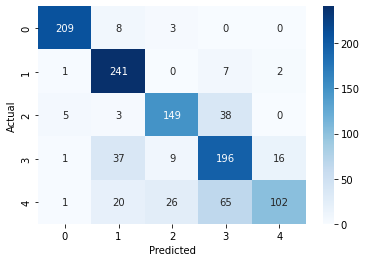

test accuracy : 78.75329236172081


In [ ]:
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
  X_test,Y_test = test_generator.next()
  y_prob.append(resnet_model_omicron.predict(X_test))
  y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]


out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix,cmap='Blues', annot=True,fmt='d')
plt.show()
print('test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

# thanks to https://github.com/jakkcoder/ResNet50/blob/master/ResNet50.ipynb for the confusion matrix code

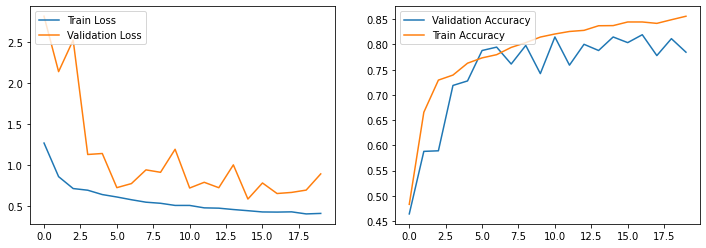

In [ ]:
#plot metrics
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[1].plot(history.history['val_accuracy'])
axes[1].plot(history.history['accuracy'])
axes[0].legend(['Train Loss', 'Validation Loss'], loc=2)
axes[1].legend(['Validation Accuracy', 'Train Accuracy'], loc=2);

# The Saved ***Omicron-Model***

In [ ]:
filepath = './saved_omicron_model.h5'
save_model(resnet_model_omicron, filepath, save_format='h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
